## Mean Curvature Flow (Snapshot 4)

In [1]:
# Importaciones
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation # animaciones
from IPython.display import HTML # ver animaciones en notebook
import matplotlib.animation
from IPython.display import display, clear_output

In [2]:
# Si es 0, todas las animaciones se guardan como gif
# Si es 1, todas las animaciones se muestraan en el inline de Jupyter
show_anims = 0

### Contexto

Se considera una función suave $\varphi$ en un dominio cerrado conexo $\Omega \subset \mathbb{R}^2$, sea $\Gamma = \{ x \in \Omega \, | \, \varphi(x) = 0 \}$, una curva cerrada.

Se conoce que el campo normal unitario $N$ (outward) de esta curva es
$$
    N(x) = \frac{\nabla\varphi(x)}{|\nabla \varphi(x)|}
$$

La curvatura $\kappa$ se puede calcular como
\begin{align*}
\kappa = \nabla \cdot N &= \nabla \cdot  \frac{\nabla\varphi(x)}{|\nabla \varphi(x)|}\\
&= (\varphi_x^2 \varphi_{yy} - 2\varphi_x\varphi_y \varphi_{xy}+\varphi_y^2\varphi_{xx} )/|\nabla \varphi|^3
\end{align*}

El efecto del flujo de curvatura se modela bajo la EDP
$$\varphi_t = b\kappa |\nabla \varphi|$$
donde $b$ es una constante que representa la velocidad del flujo.

En el caso que $\varphi$ sea una función de distancia con signo, esto es, una función que es negativa en el interior de la curva, positiva en el exterior, y su gradiente siempre tiene norma 1, entonces la EDP se simplifica a
$$\varphi_t = b\Delta \varphi$$


In [3]:
#Funciones auxiliares preliminares
#Entrega una grilla que corresponde a una funcion evaluada en distintas casillas de el cuadrado [-1,1]^2 discretizado (auxiliada por ChatGPT)
def to_grid(func, N):
    x_values = np.linspace(-1, 1, N)
    y_values = np.linspace(-1, 1, N)

    # Create a grid of coordinates
    X, Y = np.meshgrid(x_values, y_values)

    # Evaluate the function at each point in the grid
    Z = func(X, Y)

    return Z, x_values[1]-x_values[0]

#Anima
def anima_array(hist,title,interva=10,s_min = -1, s_max = 1):
    fig, ax = plt.subplots()
    n = hist[0].shape[0]
    # Funcion para animar
    def animate(i):
        #Imitamos el codigo del lab 0
        ax.clear() # limpiar ejes
        ax.contour(hist[i], levels=[0], colors='black')
        ax.contourf(hist[i])
        #ax.imshow(awa2[i], cmap='hot')
        #ax.colorbar()
        ticks = np.linspace(s_min,s_max,5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks(labels=ticks,ticks=np.linspace(0,n-1,5))
        plt.yticks(labels=ticks,ticks=np.linspace(0,n-1,5))
        ax.set_title(title)
        #ax.text(0.85, 0.9, f"t = "+str(i*dt), horizontalalignment ='left', verticalalignment ='center', transform = ax.transAxes)
        #ax.legend(loc = "upper left")

    animation = matplotlib.animation.FuncAnimation(fig, animate, frames = len(hist) , interval = interva , repeat = True)

    return animation



#Anima con imagen de fondo
def anima_array_imagen(hist,title,img,interva=10,s_min = -1, s_max = 1):
    fig, ax = plt.subplots()
    n = hist[0].shape[0]
    # Funcion para animar
    def animate(i):
        #Imitamos el codigo del lab 0
        ax.clear() # limpiar ejes
        ax.imshow(img,cmap='gray')
        ax.contour(hist[i], levels=[0], colors='red')


        #ax.contourf(hist[i])
        #ax.imshow(awa2[i], cmap='hot')
        #ax.colorbar()
        ticks = np.linspace(s_min,s_max,5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks(labels=ticks,ticks=np.linspace(0,n-1,5))
        plt.yticks(labels=ticks,ticks=np.linspace(0,n-1,5))
        ax.set_title(title)
        #ax.text(0.85, 0.9, f"t = "+str(i*dt), horizontalalignment ='left', verticalalignment ='center', transform = ax.transAxes)
        #ax.legend(loc = "upper left")

    animation = matplotlib.animation.FuncAnimation(fig, animate, frames = len(hist) , interval = interva , repeat = True)

    return animation

### Esquema de diferencia finita directo (sin usar signed distance fuction)

In [4]:
#Me gustaria dejar el borde fijo con los valores de la phi_0, esto es, la funcion original

#Diferencias finitas para primeras derivadas
# (second order central difference)
def fd_gradient(phi_0,h):
    phi_pad = np.pad(phi_0, 1, mode='maximum')
    dif_x = (np.roll(phi_pad, -1, axis=1) - np.roll(phi_pad, 1, axis=1))/(2*h)
    dif_y = (np.roll(phi_pad, -1, axis=0) - np.roll(phi_pad, 1, axis=0))/(2*h)

    return dif_x[1:-1, 1:-1], dif_y[1:-1, 1:-1]

#Diferencias finitas para segundas derivadas
def fd_hessian(phi_0,h):
    phi_pad = np.pad(phi_0, 1, mode='maximum')
    dif_x = (np.roll(phi_pad, -1, axis=1) + np.roll(phi_pad, 1, axis=1) - 2*phi_pad)/(h*h)
    dif_y = (np.roll(phi_pad, -1, axis=0) + np.roll(phi_pad, 1, axis=0) - 2*phi_pad)/(h*h)

    return dif_x[1:-1, 1:-1], dif_y[1:-1, 1:-1]


In [5]:
def MCF_1(phi_0,n_iter,dx,dt,b):

    phi = phi_0.copy()
    phi_array = [phi]

    for i in range(n_iter):
        grad_x,grad_y = fd_gradient(phi,dx)
        hess_x,hess_y = fd_hessian(phi,dx)
        _, hess_xy = fd_gradient(grad_x,dx)

        norm_grad = np.sqrt( grad_x * grad_x + grad_y * grad_y )
        curv = grad_x * grad_x * hess_y - 2 * grad_x * grad_y * hess_xy  + grad_y * grad_y * hess_x


        phi = phi + (dt * curv * b) / (norm_grad * norm_grad)

        phi_array.append(phi.copy())

    return phi, phi_array

Test con circulo


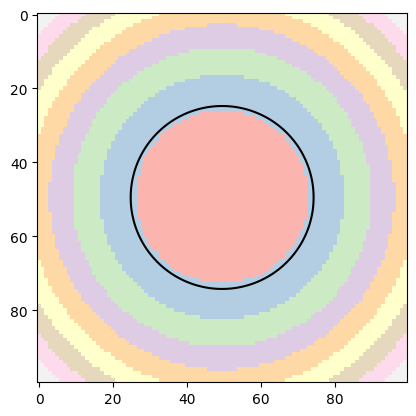

In [5]:
circ = lambda x,y: x**2 + y**2 - 0.5**2
N = 100
phi_0, dx = to_grid(circ,N)
plt.imshow(phi_0, cmap='Pastel1')
plt.contour(phi_0, levels=[0], colors='black')
#plt.colorbar()
plt.show()

In [7]:
tmp_phi, tmp_phi_array = MCF_1(phi_0,1000,dx,0.01,0.01)

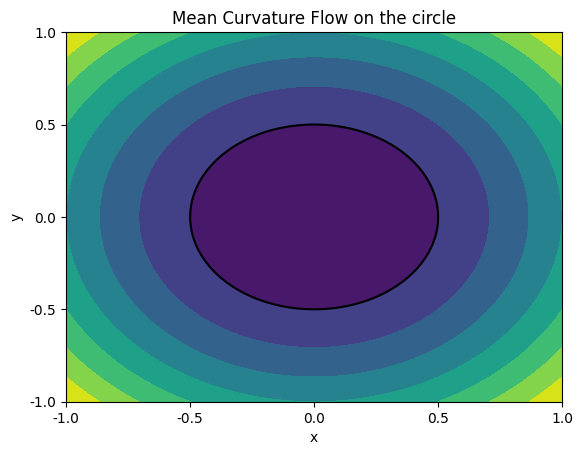

In [26]:
animation = anima_array(tmp_phi_array,"Mean Curvature Flow on the circle")


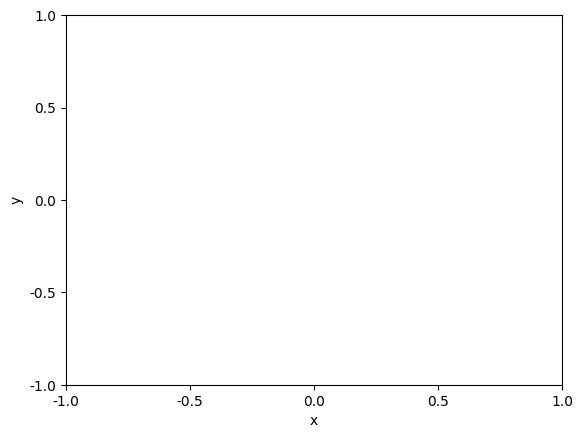

In [32]:
if show_anims:
    HTML(animation.to_html5_video())
else:
    animation.save('anims/mcf1_circle.gif', writer='pillow')

In [ ]:
def heart(x,y):
    return np.abs( y - 0.75*np.cbrt(x**2) ) - 0.5 * np.sqrt(1-x**2)

N = 100
phi_0, dx = to_grid(heart,N)
plt.imshow(phi_0, cmap='Pastel1')
plt.contour(phi_0, levels=[0], colors='black')
#plt.colorbar()
plt.show()

In [ ]:
tmp_phi, tmp_phi_array = MCF_1(phi_0,2000,dx,0.01,0.01)
animation = anima_array(tmp_phi_array,"Mean Curvature Flow on the heart")
#HTML(animation.to_html5_video())

### Esquema de diferencia finita directo ( **usando** signed distance fuction)

El proceso de transformar una función $\varphi$ a una función de distancia con signo se llama reinicialización, considerando la forma sencilla que toma la EDP en este caso, puede parecer deseable, pero se debe tener en cuenta que para que la EDP sea cierta, en cada paso del proceso de diferencia finita la función debe ser de distancia por signo, por ende tal reinicialización debe aplicarse antes de todo paso.

Una forma de reinicializar una función $\varphi$ es evolucionar la función a traves de la siguiente EDP

$$
\varphi_t +  sgn(\varphi_0)(|\nabla \varphi|-1) = 0
$$

Donde $sgn(\varphi_0)$ es una función que es negativa en el interior del contorno, $0$ en el borde y positiva en el exterior, la EDP se puede interpretar como una de transporte bajo la velocidad $-sgn(\varphi_0) N$.

Lo ideal seria resolverla a un regimen estable.

Se suaviza la función signo tomando

$$
    S(\varphi_0) = \frac{\varphi_0}{\sqrt{\varphi_0^2 + |\nabla \varphi_0|^2(\Delta x)^2}}
$$

Al discretizar $sgn(\varphi_0)|\nabla \varphi|$, calcular la norma como se realizo antes con la curvatura (usar diferencias centradas) es inestable, por ende este termino se discretiza de la siguiente manera (esquema de Gudonov):

In [6]:


#Calcula el gradiente usando esquemas no simetricos (forward y backward)
def fd_gradient_nonsym(phi_0,h):
    phi_pad = np.pad(phi_0, 1, mode='maximum')
    dif_x_forw = (np.roll(phi_pad, -1, axis=1) - phi_pad)/(h)
    dif_x_back = (phi_pad - np.roll(phi_pad, 1, axis=1))/(h)
    dif_y_forw = (np.roll(phi_pad, -1, axis=0) - phi_pad)/(h)
    dif_y_back = (phi_pad - np.roll(phi_pad, 1, axis=0))/(h)

    return dif_x_forw[1:-1, 1:-1],dif_x_back[1:-1, 1:-1], dif_y_forw[1:-1, 1:-1],dif_y_back[1:-1, 1:-1]

#Elige que aproximacion usar de acuerdo al esquema de Gudonov
def gudonov_choice(a,x_forw,x_back,y_forw,y_back):
    x_chosen = np.zeros(x_forw.shape)
    y_chosen = np.zeros(y_forw.shape)
    for i in range( x_forw.shape[0] ):
        for j in range( x_forw.shape[1] ):
            if (a[i,j]*x_forw[i,j] > 0) and (a[i,j]*x_back[i,j] > 0):
                x_chosen[i,j] = x_back[i,j]
            elif  (a[i,j]*x_forw[i,j] < 0) and (a[i,j]*x_back[i,j] < 0):
                x_chosen[i,j] = x_forw[i,j]
            elif (a[i,j]*x_forw[i,j] >= 0) and (a[i,j]*x_back[i,j] <= 0):
                x_chosen[i,j] = 0
            elif (a[i,j]*x_forw[i,j] <= 0) and (a[i,j]*x_back[i,j] >= 0):
                if np.abs(a[i,j]*x_forw[i,j]) < np.abs(a[i,j]*x_back[i,j]):
                    x_chosen[i,j] = x_back[i,j]
                else:
                    x_chosen[i,j] = x_forw[i,j]

        for i in range( y_forw.shape[0] ):
            for j in range( y_forw.shape[1] ):
                if (a[i,j]*y_forw[i,j] > 0) and (a[i,j]*y_back[i,j] > 0):
                    y_chosen[i,j] = y_back[i,j]
                elif  (a[i,j]*y_forw[i,j] < 0) and (a[i,j]*y_back[i,j] < 0):
                    y_chosen[i,j] = x_forw[i,j]
                elif (a[i,j]*y_forw[i,j] >= 0) and (a[i,j]*y_back[i,j] <= 0):
                    y_chosen[i,j] = 0
                elif (a[i,j]*x_forw[i,j] <= 0) and (a[i,j]*y_back[i,j] >= 0):
                    if np.abs(a[i,j]*y_forw[i,j]) < np.abs(a[i,j]*y_back[i,j]):
                        y_chosen[i,j] = y_back[i,j]
                    else:
                        y_chosen[i,j] = y_forw[i,j]
    #En realidad creo que puedo hacerlo too en un loop
    return x_chosen, y_chosen

#Formula de Rouy Tourin: Dan una aproximacion para los terminos phi_x ^2, phi_y^2
def RouyTourin_Formula(a,x_forw,x_back,y_forw,y_back):
    x_chosen = np.zeros(x_forw.shape)
    y_chosen = np.zeros(y_forw.shape)


    for i in range( x_forw.shape[0] ):
        for j in range( x_forw.shape[1] ):
            if a[i,j] > 0:
                a_x = x_back[i,j]; b_x = x_forw[i,j]
                a_y = y_back[i,j]; b_y = y_forw[i,j]
            elif a[i,j] < 0:
                a_x = x_forw[i,j]; b_x = x_back[i,j]
                a_y = y_forw[i,j]; b_y = y_back[i,j]
            else:
                a_x = 0;           b_x = 0
                a_y = 0;           b_y = 0

            x_chosen[i,j] = max(max(a_x,0)**2,min(b_x,0)**2)
            y_chosen[i,j] = max(max(a_y,0)**2,min(b_y,0)**2)

    return x_chosen, y_chosen

#Calcula la función (en grilla) de la funcion signo sugerida arriba
def smoothed_sgn(phi_0,dx):
    phi = phi_0.copy()

    grad_x,grad_y = fd_gradient(phi,dx)
    norm_grad_squared = grad_x * grad_x + grad_y * grad_y

    return (phi) / (phi * phi + dx * dx * norm_grad_squared)

def smoothed_sgn_2(phi_0,dx):
    phi = phi_0.copy()


    return (phi) / (phi * phi + dx * dx )

#Calcula la función (en grilla) de la funcion signo sugerida arriba, discretizando el gradiente con roy tourin
def smoothed_sgn_RT(phi_0,dx):
    phi = phi_0.copy()

    x_f,x_b,y_f,y_b = fd_gradient_nonsym(phi_0,dx)
    x_chos, y_chos = RouyTourin_Formula(np.sign(phi_0),x_f,x_b,y_f,y_b)

    return (phi) / (phi * phi + dx * dx * (x_chos + y_chos))

In [27]:
#Evoluciona la funcion a traves de la EDP de reinicilizacion
def reinit_fd(phi_0,n_iter,dx,dt):

    phi = phi_0.copy()
    phi_array = [phi]
    smth_sgn = discontinuous_sgn(phi_0)

    for i in range(n_iter):
        print("A.MAX: ", np.max(phi))
        x_f,x_b,y_f,y_b = fd_gradient_nonsym(phi,dx)
        #x_chos, y_chos = gudonov_choice(smth_sgn,x_f,x_b,y_f,y_b)
        x_chos, y_chos = RouyTourin_Formula(smth_sgn,x_f,x_b,y_f,y_b)
        norm_grad = np.sqrt( x_chos + y_chos )
        #norm_grad = np.sqrt(x_chos * x_chos + y_chos * y_chos )

        phi_1 = phi - dt * smth_sgn * ( norm_grad - 1)

        x_f,x_b,y_f,y_b = fd_gradient_nonsym(phi_1,dx)
        #x_chos, y_chos = gudonov_choice(smth_sgn,x_f,x_b,y_f,y_b)
        x_chos, y_chos = RouyTourin_Formula(smth_sgn,x_f,x_b,y_f,y_b)
        norm_grad = np.sqrt( x_chos + y_chos )

        phi_2 = phi_1 - dt * smth_sgn * ( norm_grad - 1)

        phi_1_2 = 0.75*phi + 0.25*phi_2

        x_f,x_b,y_f,y_b = fd_gradient_nonsym(phi_1_2,dx)
        #x_chos, y_chos = gudonov_choice(smth_sgn,x_f,x_b,y_f,y_b)
        x_chos, y_chos = RouyTourin_Formula(smth_sgn,x_f,x_b,y_f,y_b)
        norm_grad = np.sqrt( x_chos + y_chos )

        phi_3_2 = phi_1_2 - dt * smth_sgn * ( norm_grad - 1)

        phi = (1/3)*phi+(2/3)*phi_1_2

        phi_array.append(phi.copy())

    return phi,phi_array

Test con circulo

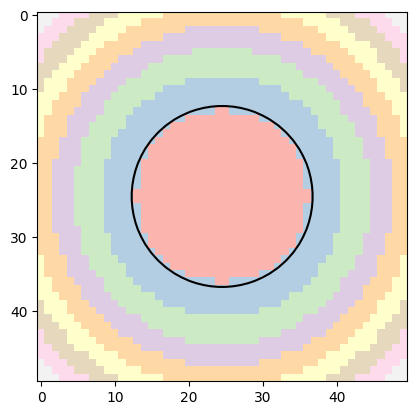

In [28]:
circ = lambda x,y: x**2 + y**2 - 0.5**2
N = 50
phi_0, dx = to_grid(circ,N)
plt.imshow(phi_0, cmap='Pastel1')
plt.contour(phi_0, levels=[0], colors='black')
#plt.colorbar()
plt.show()

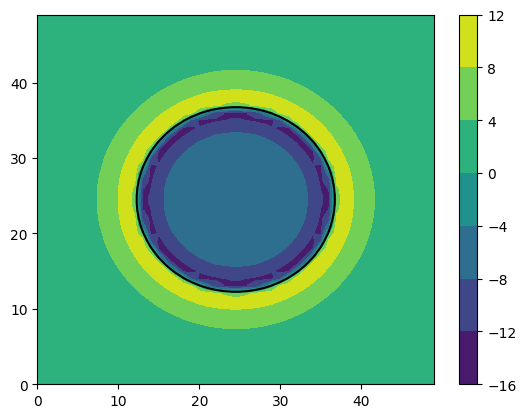

In [21]:
N = 50
phi_0, dx = to_grid(circ,N)
#plt.imshow(smoothed_sgn(phi_0,dx))
lol = plt.contourf(smoothed_sgn(phi_0,dx))
plt.contour(phi_0, levels=[0], colors='black')
plt.colorbar(lol)
plt.show()

In [24]:
def discontinuous_sgn(phi_0):
    return np.sign(phi_0)

In [43]:
tmp_phi, tmp_phi_array = reinit_fd(phi_0,250,dx,0.01)

A.MAX:  1.75
A.MAX:  1.7441306316895262
A.MAX:  1.7382832475505612
A.MAX:  1.732457847016061
A.MAX:  1.7266544295162043
A.MAX:  1.7208729944783703
A.MAX:  1.7151135413271195
A.MAX:  1.7093760694841698
A.MAX:  1.7036605783683765
A.MAX:  1.6979670673957101
A.MAX:  1.6922955359792338
A.MAX:  1.686645983529081
A.MAX:  1.6810184094524332
A.MAX:  1.6754128131534969
A.MAX:  1.6698291940334802
A.MAX:  1.6642675514905703
A.MAX:  1.6587278849199087
A.MAX:  1.6532101937135684
A.MAX:  1.6477144772605294
A.MAX:  1.6422407349466541
A.MAX:  1.6367889661546628
A.MAX:  1.6313591702641093
A.MAX:  1.6259513466513549
A.MAX:  1.6205654946895431
A.MAX:  1.615201613748575
A.MAX:  1.6098597031950816
A.MAX:  1.6045397623923983
A.MAX:  1.5992417907005385
A.MAX:  1.5939657874761668
A.MAX:  1.5887117520725709
A.MAX:  1.5834796838396346
A.MAX:  1.5782695821238106
A.MAX:  1.5730814462680915
A.MAX:  1.5679152756119823
A.MAX:  1.5627710694914696
A.MAX:  1.5576488272389954
A.MAX:  1.5525485481834256
A.MAX:  1.54747023

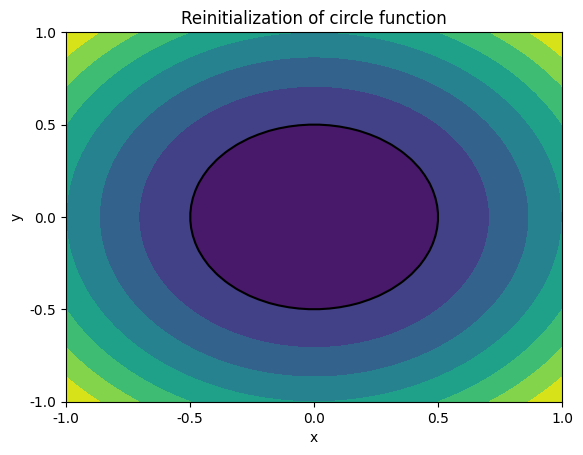

In [35]:
animation = anima_array(tmp_phi_array,"Reinitialization of circle function")
animation.save('anims/test.gif', writer = 'pillow')

In [ ]:
circ = lambda x,y: x**2 + y**2 - 0.5**2
N = 50
phi_0, dx = to_grid(circ,N)
contourf_ = plt.contourf(smoothed_sgn_2(phi_0,dx)/np.max(smoothed_sgn_2(phi_0,dx)))
plt.contour(smoothed_sgn_2(phi_0,dx), levels=[0], colors='black')

cbar = plt.colorbar(contourf_)

### Esquema de diferencia finita directo ( **usando** scikit.fmm)

La libreria scikit.fmm contiene una funcion distance que transforma una función grilla a una función grilla que es la función distancia de level $0$ de la función.

In [ ]:
!pip install scikit-fmm #scikit- fast marching method

In [46]:
import skfmm

In [ ]:
def MCF_3(phi_0, max_iter, b , dx , dt): #Codigo chopeado de chatGPT y snapshot anterior

    #phi = phi_0.copy()
    phi_hist = []
    phi = skfmm.distance(phi_0, dx=dx, order=1)
    for _ in range(max_iter):
        phi = np.pad(phi, 1, mode='maximum')

        # Compute the Laplacian using central difference scheme
        laplacian = ((np.roll(phi, 1, axis=0) + np.roll(phi, -1, axis=0) + \
                    np.roll(phi, 1, axis=1) + np.roll(phi, -1, axis=1) - \
                    4 * phi) / (dx * dx))

        phi = phi + dt*b*laplacian

        phi = skfmm.distance(phi[1:-1, 1:-1], dx=dx, order=1)

        phi_hist.append(phi.copy())

    return phi, phi_hist

In [ ]:
N = 100
phi_0, dx = to_grid(circ,N)
plt.imshow(phi_0, cmap='Pastel1')
plt.contour(phi_0, levels=[0], colors='black')
#plt.colorbar()
plt.show()

In [ ]:
tmp_phi, tmp_phi_array = MCF_3(phi_0,815, b = 0.01,dx = 0.02,dt = 0.01)

In [ ]:
animation = anima_array(tmp_phi_array,"Mean curvature flow on the circle")
HTML(animation.to_html5_video())

In [ ]:
N = 100
phi_0, dx = to_grid(heart,N)
plt.imshow(phi_0, cmap='Pastel1')
plt.contour(phi_0, levels=[0], colors='black')
#plt.colorbar()
plt.show()

In [ ]:
tmp_phi, tmp_phi_array = MCF_3(phi_0,900, b = 0.01,dx = 0.02,dt = 0.01)

In [ ]:
animation = anima_array(tmp_phi_array,"Mean curvature flow on the heart")
HTML(animation.to_html5_video())

In [ ]:
def square(x,y):
    return np.maximum(np.abs(x),np.abs(y)) - 0.9
N = 100
phi_0, dx = to_grid(square,N)
plt.imshow(phi_0, cmap='Pastel1')
plt.contour(phi_0, levels=[0], colors='black')
#plt.colorbar()
plt.show()

In [ ]:
tmp_phi, tmp_phi_array = MCF_3(phi_0,3000, b = 0.01,dx = 0.02,dt = 0.01)

In [ ]:
animation = anima_array(tmp_phi_array,"Mean curvature flow on the square")
HTML(animation.to_html5_video())

# Imagenes

La idea es evolucionar una curva grande a traves de flujo de curvatura media pero que el flujo se detenga en las zonas que una función de intensidad $I$ tenga un gradiente alto, si $I$ representa una imagen en blanco y negro, se deberia observar que la curva reconoce secciones de imagenes donde ocurre un cambio de contraste, i.e. aparece un objeto.

Esto se puede lograr evolucionando el contorno de acuerdo a la siguiente ecuación

$$
\varphi_t = g |\nabla \varphi | \, \kappa+ \nabla g \cdot \nabla \varphi
$$

Donde $g$ es una función positiva y estrictamente decreciente  que cumple $g(0) = 1$ y $\lim_{s\to 0} g(s) = 0$, en la EDP la función g esta evaluada en $|\nabla I|$

En particular si $\varphi$ es una función de distancia con signo


$$
\varphi_t = g \Delta \varphi+ \nabla g \cdot \nabla \varphi
$$

In [9]:
from PIL import Image #Pillow

In [10]:
#La funcion g del enunciado
def g(x):
    return 1/(1+x*x)


In [11]:
# Flujo segmentador
def SF_1(Img_0,max_iter,dt,b):
    def square(x,y):
        return np.maximum(np.abs(x),np.abs(y)) - 0.9

    N = Img_0.shape[0]
    phi, dx = to_grid(square,N)
    dx = float(dx)
    phi = skfmm.distance(phi, dx=dx, order=1)
    phi_hist = [phi]


    grad_I_x,grad_I_y = fd_gradient(Img_0,dx)
    norm_grad_I  = np.sqrt( grad_I_x*grad_I_x + grad_I_y*grad_I_y)
    g_I= g(norm_grad_I)
    grad_gI_x,grad_gI_y = fd_gradient(g_I,dx)

    for _ in range(max_iter):

        grad_x,grad_y = fd_gradient(phi,dx)
        hess_x,hess_y = fd_hessian(phi,dx)
        _, hess_xy = fd_gradient(grad_x,dx)

        norm_grad = np.sqrt( grad_x * grad_x + grad_y * grad_y )
        curv = grad_x * grad_x * hess_y - 2 * grad_x * grad_y * hess_xy  + grad_y * grad_y * hess_x

        phi = np.pad(phi, 1, mode='maximum')

        # Compute the Laplacian using central difference scheme
        laplacian = ((np.roll(phi, 1, axis=0) + np.roll(phi, -1, axis=0) + \
                    np.roll(phi, 1, axis=1) + np.roll(phi, -1, axis=1) - \
                    4 * phi) / (dx * dx))


        phi = phi[1:-1, 1:-1] + dt*b*laplacian[1:-1, 1:-1]*g_I + dt*b*(grad_gI_x*grad_x + grad_gI_y*grad_x)


        phi = skfmm.distance(phi, dx=dx, order=1)

        phi_hist.append(phi.copy())

    return phi, phi_hist


In [12]:
# Flujo segmentador
def SF_2(Img_0,max_iter,dt,b):
    def square(x,y):
        return np.maximum(np.abs(x),np.abs(y)) - 0.9

    N = Img_0.shape[0]
    phi, dx = to_grid(square,N)
    dx = float(dx)
    #phi = skfmm.distance(phi, dx=dx, order=1)
    phi_hist = [phi]


    grad_I_x,grad_I_y = fd_gradient(Img_0,dx)
    norm_grad_I  = np.sqrt( grad_I_x*grad_I_x + grad_I_y*grad_I_y)
    g_I= g(norm_grad_I)
    grad_gI_x,grad_gI_y = fd_gradient(g_I,dx)

    for _ in range(max_iter):

        grad_x,grad_y = fd_gradient(phi,dx)
        hess_x,hess_y = fd_hessian(phi,dx)
        _, hess_xy = fd_gradient(grad_x,dx)

        norm_grad = np.sqrt( grad_x * grad_x + grad_y * grad_y )
        curv = grad_x * grad_x * hess_y - 2 * grad_x * grad_y * hess_xy  + grad_y * grad_y * hess_x

        phi = np.pad(phi, 1, mode='maximum')

        # Compute the Laplacian using central difference scheme
        laplacian = ((np.roll(phi, 1, axis=0) + np.roll(phi, -1, axis=0) + \
                    np.roll(phi, 1, axis=1) + np.roll(phi, -1, axis=1) - \
                    4 * phi) / (dx * dx))


        phi = phi[1:-1, 1:-1] + dt*b*curv*norm_grad*g_I + dt*b*(grad_gI_x*grad_x + grad_gI_y*grad_x)


        #phi = skfmm.distance(phi, dx=dx, order=1)

        phi_hist.append(phi.copy())

    return phi, phi_hist


In [13]:

#Rutina de ChatGPT para cargar la imagen con Pillow
# Load the image
image = Image.open("smallapple.jpg")

# Convert the image to grayscale
gray_image = image.convert('L')

# Convert the image to a NumPy array
image_array = np.array(gray_image)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\arena\\Documents\\Bases_de_Datos\\edpn\\proyecto\\EDPN\\smallapple.jpg'

In [ ]:
max_asp = max(image_array.shape)

image_array = np.array(gray_image.resize((max_asp,max_asp)))

In [ ]:
#test
max_asp = 50

image_array = np.array(gray_image.resize((max_asp,max_asp)))

In [ ]:
test_rec, test_rec_hist = SF_2(image_array,2000,0.01,0.01)

In [14]:
rec_anim = anima_array_imagen(test_rec_hist,'test',image_array)
HTML(rec_anim.to_html5_video())

NameError: name 'test_rec_hist' is not defined

Almenos con Euler-Forward esta divergiendo, cosas a probar:
* Probar con Runge-Kutta
* Aproximar el gradiente de otra forma (?)
* Encontrar donde sale esto en al bibliografia